# Question 1

Are contributors of comments (commit comments, issue comments, pull request comments) more likely to contribute to packages they depend on (or to packages that depend on them) than to other packages?

*** I think to answer this question we need all comments of users who have contributed on a package... to this end, we need to scrap github to find all comments of a user. ( am I right? or we just consider the downloaded comments of packages)

*** Which types of plot and analysis is helpful to find out more about this question?

In [30]:
import pandas
import matplotlib.pyplot as plt
import seaborn
import collections
import itertools
import numpy as np
import warnings
import subprocess
import requests
import lifelines


import sys
sys.path.append('..')

from helper import load_data , load_repo ,read_comments , GIT_API
warnings.filterwarnings('ignore')

%matplotlib inline

palet = seaborn.color_palette('hls', 8)[0:6]

In [70]:
all_comments = (
    read_comments()
    #[lambda x: x['author_assoc'] != 'NONE']
    .assign(created_at = lambda x: pandas.to_datetime(x['created_at']))
)
all_comments.head()

,Name,user_login,author_assoc,created_at,type
0,itertools,Antti,NONE,2017-09-05 10:03:23,cmt
1,itertools,bluss,OWNER,2017-09-05 21:42:56,cmt
2,itertools,DanielKeep,CONTRIBUTOR,2015-06-06 03:52:21,cmt
3,itertools,bluss,OWNER,2015-06-06 07:33:39,cmt
4,itertools,bluss,OWNER,2015-06-06 07:34:31,cmt


In [71]:
df_pkgdpd_relation = (
    pandas.read_csv('../data/package_dependencies_time.csv.gz',compression='gzip',
                    parse_dates=['fst_release','lst_release','first_time','last_time'])
    [['package','target']]
)
df_pkgdpd_relation.head()

,package,target
0,BrewStillery,gtk
1,BrewStillery,regex
2,BrewStillery,gio
3,BrewStillery,gdk
4,ConExpression,rand


#### Group comments by user and package

In [72]:
new_df = (
    all_comments
    [['Name','user_login','author_assoc']]
    .assign(count = 1)
    .groupby(['user_login','Name','author_assoc'])
    .sum()
    .reset_index()
)
new_df.shape

(11777, 4)

#### Number of dependent packages a user commented on

*** does this method work properly? am I correct in my approach?

In [73]:
#this function checks all packages a user commented on
def check_dep(row):
    pkgs = new_df[lambda x: x['user_login'] == row['user_login']]['Name']
    parray = pkgs[pkgs.apply(lambda x: x != row['Name'])].values
    relcount = 0
    for item in parray:
        if (item in df_pkgdpd_relation[lambda x: x['package'] == row['Name']]['target'].values 
            or row['Name'] in df_pkgdpd_relation[lambda x: x['package'] == item]['target'].values):
            relcount+=1
    return relcount

In [74]:
# test dataset
df_tt = new_df[lambda x: x['user_login'] == '0xbrt']

new_df['rela_status'] = new_df.apply(lambda x: check_dep(x),axis=1)
#df_tt['rela_status'] = df_tt.apply(lambda x: check_dep(x),axis=1)

new_df.head()

,user_login,Name,author_assoc,count,rela_status
0,007pig,mio,NONE,1,0
1,00imvj00,gotham,NONE,1,0
2,00shiv,image,NONE,3,0
3,0610919566,hyper,NONE,2,0
4,0X1A,cargo,NONE,2,1


[Text(0, 0.5, 'Comment on packages'), Text(0.5, 0, 'Author association')]

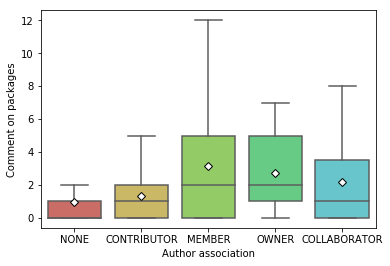

In [81]:
plt.rcParams["figure.figsize"] = (6,4)
fig, ax = plt.subplots()

seaborn.boxplot(
    x='author_assoc', 
    y='rela_status', 
    data=(
        new_df[['author_assoc','rela_status']]
    ),
    palette=palet,
    ax=ax,
    fliersize=1,
    showmeans=True,
    showfliers=False,
    meanprops=dict(marker='D', markeredgecolor='black', markerfacecolor='white')
)

ax.set(
    ylabel='Comment on packages',
    xlabel='Author association' 
)

In [86]:
df_tmp2 = (
    all_comments
    .drop_duplicates(subset=['Name','user_login','author_assoc'])
    .dropna()
)
df_tmp2['rela_status'] = df_tmp2.apply(lambda x: check_dep(x),axis=1)

In [87]:
df_plot = (
    df_tmp2[['created_at','author_assoc','rela_status']]
    .groupby([pandas.Grouper(key='created_at',freq='1M'),'author_assoc'])
    .describe().reset_index()
)
df_plot.columns = ['created_at','author_assoc','count','mean','std','min','25%','median','75%','max']

*** this plot is so ugly and I think it's not useful :) how can I change it to a useful one?

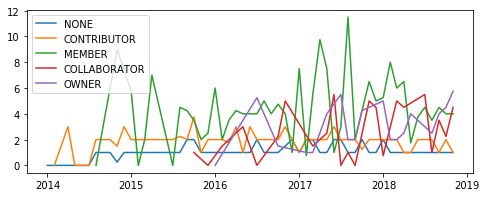

In [88]:
plt.rcParams["figure.figsize"] = (8,3)
fig, ax = plt.subplots()
for item in df_plot.author_assoc.unique():
    ax.plot(df_plot[lambda x: x['author_assoc'] == item]['created_at'],df_plot[lambda x: x['author_assoc'] == item]['75%'])
    
ax.legend(df_plot.author_assoc.unique())